## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [2]:
# Path to the miner directory
proj_path = os.path.join(os.path.expanduser('~'),'Projects','miner3')
input_path = os.path.join(proj_path, 'miner_mindata')

# create name for results folder where output files will be saved
resultsFolder = "results_miner"

# create results directory
resultsDirectory = os.path.join(proj_path,resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)
# name of the folder containing the miner network
networkFolder = "results_minCorrelation_0o2_50_allFiles"
network_path = os.path.join(proj_path, networkFolder)

## Load primary data

In [3]:
# Load expression Data
expressionFile = os.path.join(input_path, "expression","IA12Zscore.csv")
id_names = os.path.join(input_path, "identifier_mappings.txt")
expressionData, conversionTable = miner.preprocess(expressionFile, id_names)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(network_path, "coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(network_path, "coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(network_path, "regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(network_path, "mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(network_path, "regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(network_path, "overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(network_path, "underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(network_path, "eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

completed identifier conversion.
16216 genes were converted. 10285 genes were dropped due to identifier mismatch


In [4]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,"survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Examine p-value distributions for signal strength

In [5]:
high_risk_ = guanSurvivalDfMMRF.index[0:round(guanSurvivalDfMMRF.shape[0]*0.30)]
low_risk_ = guanSurvivalDfMMRF.index[round(guanSurvivalDfMMRF.shape[0]*0.30):]
pats = np.hstack([low_risk_,high_risk_])

mut_pats = list(set(pats)&set(mutation_matrix.columns))
risk_status_df = pd.DataFrame(np.zeros(len(mut_pats)))
risk_status_df.index = mut_pats
risk_status_df.columns = ["high_risk"]
risk_status_df.loc[list(set(mut_pats)&set(high_risk_)),"high_risk"] = 1
risk_status_array = np.array(risk_status_df.iloc[:,0])

## Mutations

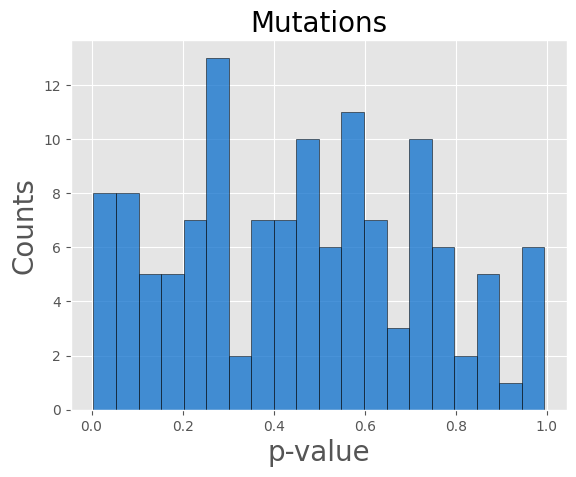

In [6]:
mut_pats = list(set(pats)&set(mutation_matrix.columns))
risk_status_df = pd.DataFrame(np.zeros(len(mut_pats)))
risk_status_df.index = mut_pats
risk_status_df.columns = ["high_risk"]
risk_status_df.loc[list(set(mut_pats)&set(high_risk_)),"high_risk"] = 1
risk_status_array = np.array(risk_status_df.iloc[:,0])
mut_status_array = np.array(mutation_matrix.loc[:,mut_pats])

mut_ps = miner.chiSquareTest(risk_status_array,mut_status_array)
_=plt.hist(mut_ps,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Counts", fontsize=20)
plt.xlabel("p-value", fontsize=20)
plt.title("Mutations", fontsize=20)
plt.savefig(os.path.join(resultsDirectory, "pvalue_distribution_mutations"),bbox_inches="tight")

# Genes

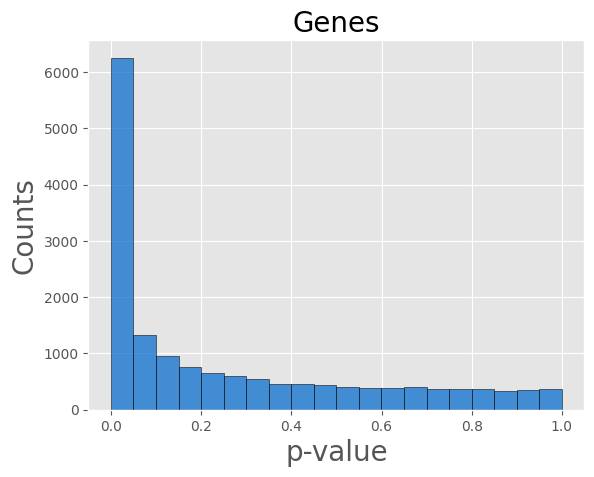

In [7]:
ts_exp, ps_exp = stats.ttest_ind(expressionData.loc[:,high_risk_],expressionData.loc[:,low_risk_],axis=1,equal_var=False)
_=plt.hist(ps_exp,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Counts", fontsize=20)
plt.xlabel("p-value", fontsize=20)
plt.title("Genes", fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"pvalue_distribution_genes"),bbox_inches="tight")

## Regulons

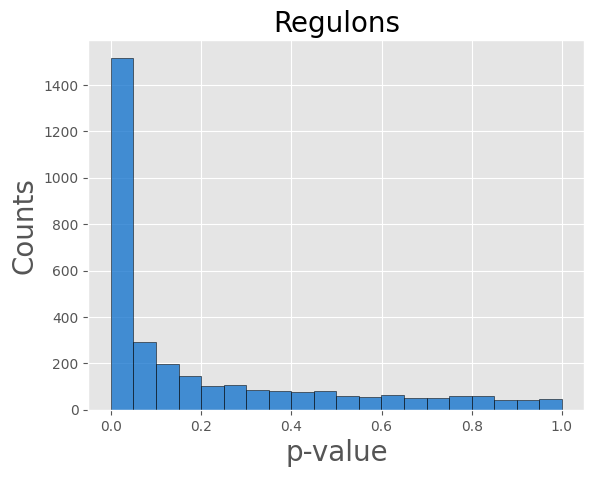

In [8]:
regulon_pats = list(set(pats)&set(diff_matrix_MMRF.columns))
risk_status_df = pd.DataFrame(np.zeros(len(regulon_pats)))
risk_status_df.index = regulon_pats
risk_status_df.columns = ["high_risk"]
risk_status_df.loc[list(set(regulon_pats)&set(high_risk_)),"high_risk"] = 1
risk_status_array = np.array(risk_status_df.iloc[:,0])
regulon_status_array = np.array(diff_matrix_MMRF.loc[:,regulon_pats])

regulon_ps = miner.chiSquareTest(risk_status_array,regulon_status_array)
_=plt.hist(regulon_ps,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Counts", fontsize=20)
plt.xlabel("p-value", fontsize=20)
plt.title("Regulons", fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"pvalue_distribution_regulons"),bbox_inches="tight")

## Programs

In [9]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(network_path, 'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [10]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(network_path, 'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

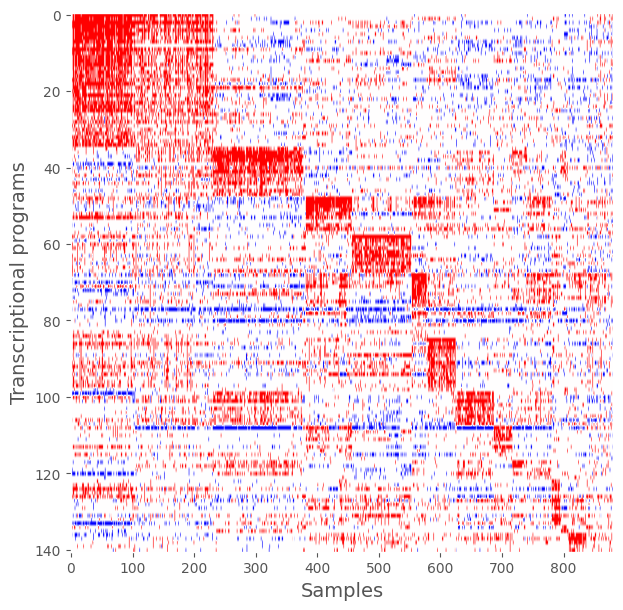

In [11]:
statesDf = miner.reduceModules(df=diff_matrix_MMRF.loc[np.hstack(program_list),np.hstack(states_list)],programs=program_list,states=states_list,stateThreshold=0.50,saveFile=os.path.join(resultsDirectory,"transcriptional_programs.pdf"))

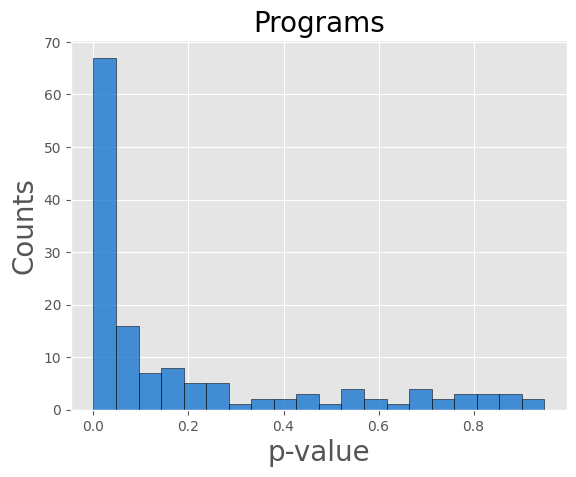

In [12]:
programs_pats = list(set(pats)&set(statesDf.columns))
risk_status_df = pd.DataFrame(np.zeros(len(programs_pats)))
risk_status_df.index = programs_pats
risk_status_df.columns = ["high_risk"]
risk_status_df.loc[list(set(programs_pats)&set(high_risk_)),"high_risk"] = 1
risk_status_array = np.array(risk_status_df.iloc[:,0])
programs_status_array = np.array(statesDf.loc[:,programs_pats])

programs_ps = miner.chiSquareTest(risk_status_array,programs_status_array)
_=plt.hist(programs_ps,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Counts", fontsize=20)
plt.xlabel("p-value", fontsize=20)
plt.title("Programs", fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"pvalue_distribution_programs"),bbox_inches="tight")

## Percent of features with p < 0.1

In [13]:
hits = len(np.array(mut_ps)[np.array(mut_ps)<=0.1])
total = len(mut_ps)
percent_mutations = 100*float(hits)/total

hits = len(np.array(ps_exp)[np.array(ps_exp)<=0.1])
total = len(ps_exp)
percent_genes = 100*float(hits)/total

hits = len(np.array(regulon_ps)[np.array(regulon_ps)<=0.1])
total = len(regulon_ps)
percent_regulons = 100*float(hits)/total

hits = len(np.array(programs_ps)[np.array(programs_ps)<=0.1])
total = len(programs_ps)
percent_programs = 100*float(hits)/total

print(percent_mutations,percent_genes,percent_regulons,percent_programs)

12.4031007751938 46.7932905772077 56.54074305338745 58.86524822695036


## Saturation plot

In [14]:
tpmFile = os.path.join(input_path,"expression","MMRF_CoMMpass_IA9_E74GTF_Salmon_Gene_TPM.txt")
tpmMMRF = pd.read_csv(tpmFile,sep="\t",index_col=0)
spike_genes = [gene for gene in tpmMMRF.index if len(gene.split("-"))<2]
tpmMMRF = tpmMMRF.loc[spike_genes,:]

ids = []
values = []
for sample in tpmMMRF.columns:
    tmp_data = tpmMMRF[sample][np.argsort(tpmMMRF[sample])][-10:]
    values.append(sum(list(tmp_data))/1000000)
    ids.append(list(tmp_data.index))
    
fraction_nonzero = 100*np.count_nonzero(tpmMMRF,axis=0)/tpmMMRF.shape[0]

plt.scatter(100*np.array(values),fraction_nonzero,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Percent of non-zero\ntranscripts", fontsize=16)
plt.xlabel("Top 10 transcripts/All transcripts", fontsize=16)
plt.title("Saturation of TPM", fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"Top10_genes_vs_TPM.pdf"), bbox_inches="tight")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/weiju/Projects/miner3/miner_mindata/expression/MMRF_CoMMpass_IA9_E74GTF_Salmon_Gene_TPM.txt'